# Modelos para treinamento

Esse notebook foi dedicado exclusivamente para treinar modelos com os dados já pré-processados (ver notebook EDA.ipynb). Vou utilizar 3 modelos para esse problema de classificação binária: *Random Forest*, *LightGBM* e *XGBoost*, e vou tentar entender um pouco os parâmetros de cada um e avaliar a eficácia dos modelos.

## *Random Forest Classifier*

O primeiro modelo que vou utilizar aqui é baseado em várias árvores de decisões (por isso o nome *forest*). Cada árvore avalia uma parcela dos dados (*bootstrap*), usando apenas uma parcela das *features* para as perguntas e respostas. Então cada árvore usa uma parte diferente dos dados, e uma parte diferente das *features*. Cada pergunta tem como o objetivo separar o conjunto de dados e torná-lo o mais homogêneo possível (Para esse *dataset* separar entre `Transported = True` e `Transported = False`). Por exemplo, durante a *Exploratory Data Analysis* (EDA) foi evidenciado que cerca de 86% das pessoas NÃO transportadas NÃO estavam em sono criogênico, enquanto que apenas 42% das pessoas transportadas NÃO estavam em sono criogênico. Essa diferença indica que `CryoSleep` pode ser uma boa *feature* para separar o conjunto de dados. O modelo em si consegue procurar correlações mais complexas entre as *features*, e por votação majoritária entre as árvores prevê a classificação de cada passageiro. 

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
import lightgbm as lgb
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

## Carregando os dados

Os dados processados são salvos em arquivos .csv no notebook EDA.ipynb. Lá é possível escolher quais *features* serão usadas no modelo, além de uma análise de distribuição e correlação com a variável alvo. 

In [19]:
proc_train = pd.read_csv('train_processed.csv')
proc_test = pd.read_csv('test_processed.csv')

Y_train = proc_train['Transported'].copy()
proc_train = proc_train.drop('Transported', axis=1)

## Separando os dados

Afim de avaliar a acurácia de cada modelo é feita uma separação dos dados em uma proporção 80/20, 80% dos dados são usados para treinar o modelo e 20% para avaliar sua performance. Lembrando que essa amostra de 20% é retirada da amostra de treino, sem usar a amostra de teste da competição.

In [4]:
X_train_split, X_test_split, Y_train_split, Y_test_split = train_test_split(
    proc_train,
    Y_train,
    test_size=.2,
    stratify=Y_train,
    random_state=11
)

Cada modelo de ML possui hiperparâmetros que definem sua maneira de operação. No caso do *Random Forest Classifier* existem hiperparâmetros como: O número de árvores, a profundidade que cada árvore pode chegar (ou seja, limita quantas perguntas cada árvore faz), o máximo de *features* que um nó considera, o número mínimo da parcela da amostra que cada árvore considera, a função matemática que avalia a qualidade de separação dos dados para cada pergunta (critério que avalia se a *feature* foi boa em fornecer informação para o modelo ou não), entre outras que não mencionei aqui.

Podemos notar que eexistem muitos hiperparâmetros que influciam na eficácia do modelo, mas existem métodos capazes de determinar a melhor combinação (ou uma das melhores combinações) de hiperparâmetros baseado na eficácia do modelo, para que não fique na base da tentativa e erro. Aqui eu uso o *Randomized Search Cross Validation* para determinar um bom conjunto de hiperparâmetros para o modelo. Nesse método você fornece valores possíveis para cada hiperparâmetro (ou um intervalo possível para a escolha), e em cada iteração é treinado um modelo com uma combinação desses hiperparâmetros. Para diminuir o custo computacional esse algoritmo testa um número pré definido da combinações desses hiperparâmetros (se fosse testar todas demoraria muito). A avaliação do desempenho do modelo é feito através da validação cruzada (*Cross Validation*), onde o algoritimo divide os dados de treinamente em X subgrupos (X é pré determinado também), treino o modelo com X-1 grupos e avalia com o grupo que ficou de fora. Esse processo é repetido, trocando o grupo que ficou de fora do treinamento por outro, até que todos passem pelo papel de ser usado pela avaliação. No final, a métrica usada pelo desempenho é dado pela média de todos os treinamentos.

In [5]:
rf_model = RandomForestClassifier(random_state=19, n_jobs=-1)
param_distributions = {
    'n_estimators': randint(100, 1000), # Número de árvores entre 100 e 999
    'max_depth': [10, 15, 20, 25, 30, None], # Profundidades para testar (None = sem limite)
    'min_samples_split': [5, 10, 15, 20], # Mínimo para dividir nó
    'min_samples_leaf': [3, 5, 7, 10],    # Mínimo por folha
    'max_features': ['sqrt'], # Features por split ('sqrt' é o default)
    'criterion': ['gini', 'entropy'],      # Critério de divisão
}
# 'max_features': ['sqrt', 'log2', 0.5]

n_iterations = 25
cv_folds=5

random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_distributions,
    n_iter=n_iterations,
    cv=cv_folds,
    scoring='accuracy', 
    verbose=2, # Mostra mais detalhes do progresso
    random_state=20, # Para reprodutibilidade da busca
    n_jobs=-1 
)

print(f"Iniciando RandomizedSearch com {n_iterations} iterações e CV={cv_folds}...")
random_search.fit(X_train_split, Y_train_split)
print("Busca concluída.")

print("\nMelhores Hiperparâmetros encontrados:")
print(random_search.best_params_)

best_rf_model = random_search.best_estimator_

Iniciando RandomizedSearch com 25 iterações e CV=5...
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Busca concluída.

Melhores Hiperparâmetros encontrados:
{'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 15, 'n_estimators': 666}


A amostra usada para previsão do modelo possui 1739 dados


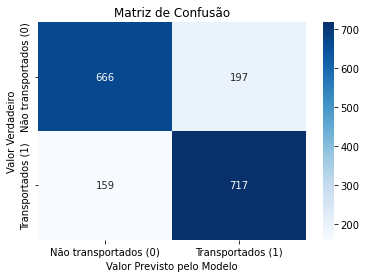

In [6]:
y_pred_split = best_rf_model.predict(X_test_split)
class_labels = ['Não transportados (0)', 'Transportados (1)']
print(f'A amostra usada para previsão do modelo possui {y_pred_split.shape[0]} dados')

cm = confusion_matrix(Y_test_split, y_pred_split)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)

plt.xlabel('Valor Previsto pelo Modelo')
plt.ylabel('Valor Verdadeiro')
plt.title('Matriz de Confusão')
plt.show()

A matriz acima possui 4 informações: Quantos passageiros o modelo falou que NÃO foram transportados e realmente NÃO foram (666 Verdadeiros negativos), quantos passageiros o modelo falou que foram transportados e realmente foram (717 verdadeiros positivos), quantos passageiros o modelo falou que foram transportadas mas na verdade não foram (197 falsos positivos) e quantas pessoas o modelo falou que não foram transportadas mas na verdade foram (159 falsos negativos).

In [7]:
report = classification_report(Y_test_split, y_pred_split, target_names=class_labels)
print("\nRelatório de Classificação:")
print(report)


Relatório de Classificação:
                       precision    recall  f1-score   support

Não transportados (0)       0.81      0.77      0.79       863
    Transportados (1)       0.78      0.82      0.80       876

             accuracy                           0.80      1739
            macro avg       0.80      0.80      0.80      1739
         weighted avg       0.80      0.80      0.80      1739



 O modelo performou bem, atingindo acurácia de ~80%, com F1-scores equilibrados de 0.79 para 'Não Transportado' e 0.80 para 'Transportado', indicando boa capacidade de predição para ambos os grupos, com uma leve vantagem no recall para identificar passageiros transportados.

## Importância das *features*

Aqui vou colocar uma classificação da importância das *features*, ou seja, quais *features* o modelo julgou mais eficaz em prever a classificação.

Importância das Features (ordenada):
TotalSpending                0.172705
ZeroSpending                 0.123070
Spa                          0.102592
FoodCourt                    0.098304
CryoSleep                    0.091691
VRDeck                       0.081645
RoomService                  0.081191
ShoppingMall                 0.069124
Age                          0.058730
HomePlanet_Earth             0.042306
HomePlanet_Europa            0.027574
GroupSize                    0.021533
HomePlanet_Mars              0.011932
Destination_55 Cancri e      0.007332
Destination_TRAPPIST-1e      0.005844
Destination_PSO J318.5-22    0.004429
dtype: float64


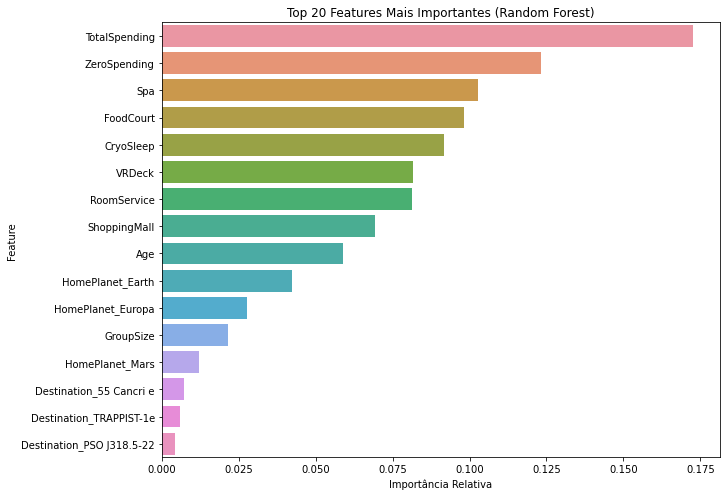

In [8]:
# Obtém as importâncias
importances = best_rf_model.feature_importances_

# Obtém os nomes das features na ordem correta
feature_names = X_train_split.columns

# Cria uma Série para combinar nomes e importâncias
feature_importance_series = pd.Series(importances, index=feature_names)

# Ordena as features pela importância (da maior para a menor)
sorted_feature_importances = feature_importance_series.sort_values(ascending=False)

# Imprime a lista ordenada
print("Importância das Features (ordenada):")
print(sorted_feature_importances)

# Visualiza as N features mais importantes
plt.figure(figsize=(10, 8)) 

# Define quantas features top você quer mostrar
top_n = 20

sns.barplot(x=sorted_feature_importances.head(top_n).values,
            y=sorted_feature_importances.head(top_n).index)

plt.title(f'Top {top_n} Features Mais Importantes (Random Forest)')
plt.xlabel('Importância Relativa')
plt.ylabel('Feature')
plt.show()

Esse passo é importante para verificar a importância das *features* existentes e criadas durante a EDA. O treinamento de um modelo de *machine learning* é um processo recursivo com o objetivo de maximizar sua eficiência. O resultado obtido sempre pode gerar *insights* sobre os dados, que são levados novamente à EDA para melhorar o pré-processamento e aumentar a acurácia do modelo. Os notebooks aqui estão totalmente adaptados à mudanças, e o desempenho obtido é verificado aqui. Durante o processo voltei diversas vezes ao notebook da EDA, desconsiderei e considerei diversas *features*, tive *insights* para criar novas e fui aprendendo mais sobre os dados. Esse projeto pode ficar indefinidamente aberto devido ao grande número de possibilidades. Vou finalizar por enquanto treinando modelos diferentes com esse mesmo conjunto de dados, mas lembrando que sempre podemos melhorar.

## *Light Gradient Boost Model*

In [9]:
lgbm_base = lgb.LGBMClassifier(random_state=42, n_jobs=-1)

param_distributions_lgbm = {
    'n_estimators': randint(100, 1200),
    'learning_rate': uniform(0.01, 0.3), # Distribuição uniforme para taxa de aprendizado
    'num_leaves': randint(20, 60), # Principal parâmetro de complexidade no LGBM
    'max_depth': [-1, 10, 15, 20], # -1 significa sem limite (num_leaves controla mais)
    'min_child_samples': randint(5, 30), # Similar a min_samples_leaf
    'subsample': [0.7, 0.8, 0.9, 1.0], # Fração de amostras por árvore
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0], # Fração de features por árvore
    'reg_alpha': [0, 0.01, 0.1, 0.5, 1], # Regularização L1
    'reg_lambda': [0, 0.01, 0.1, 0.5, 1] # Regularização L2
}

n_iterations_lgbm = 50
cv_folds_lgbm = 5

random_search_lgbm = RandomizedSearchCV(
    estimator=lgbm_base,
    param_distributions=param_distributions_lgbm,
    n_iter=n_iterations_lgbm,
    cv=cv_folds_lgbm,
    scoring='accuracy',
    verbose=1,
    random_state=42,
    n_jobs=-1
)

print(f"Iniciando RandomizedSearch para LGBM ({n_iterations_lgbm} iterações, CV={cv_folds_lgbm})...")
random_search_lgbm.fit(X_train_split, Y_train_split)
print("Busca concluída.")

print("\nMelhores Hiperparâmetros encontrados para LGBM:")
print(random_search_lgbm.best_params_)

print(f"\nMelhor score de Acurácia LGBM (cross-validated): {random_search_lgbm.best_score_:.4f}")

best_lgbm_model = random_search_lgbm.best_estimator_


y_pred_lgbm_best = best_lgbm_model.predict(X_test_split)

accuracy_lgbm_best = accuracy_score(Y_test_split, y_pred_lgbm_best)
print(f"Acurácia LGBM (Validação): {accuracy_lgbm_best:.4f}")

Iniciando RandomizedSearch para LGBM (50 iterações, CV=5)...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000904 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1634
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380
Busca concluída.

Melhores Hiperparâmetros encontrados para LGBM:
{'colsample_bytree': 1.0, 'learning_rate': 0.01165663513708072, 'max_depth': 15, 'min_child_samples': 23, 'n_estimators': 692, 'num_leaves': 27, 'reg_alpha': 0.1, 'reg_lambda': 0

## Avaliação do modelo

In [11]:
y_pred_lgbm_best = best_lgbm_model.predict(X_test_split)
print(classification_report(Y_test_split, y_pred_lgbm_best, target_names=class_labels))

                       precision    recall  f1-score   support

Não transportados (0)       0.81      0.76      0.79       863
    Transportados (1)       0.78      0.83      0.80       876

             accuracy                           0.79      1739
            macro avg       0.80      0.79      0.79      1739
         weighted avg       0.80      0.79      0.79      1739



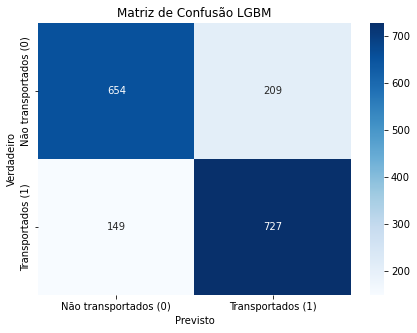

In [12]:
cm_lgbm_best = confusion_matrix(Y_test_split, y_pred_lgbm_best)

plt.figure(figsize=(7, 5))
sns.heatmap(cm_lgbm_best, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Previsto')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão LGBM')
plt.show()

## *eXtreme Gradient Boost (XGB) model*

In [13]:
xgb_base = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', n_jobs=-1)

param_distributions_xgb = {
    'n_estimators': randint(100, 1200),
    'learning_rate': uniform(0.01, 0.3 - 0.01),
    'max_depth': randint(3, 15), # XGBoost geralmente usa árvores mais rasas que RF
    'min_child_weight': randint(1, 10), # Ajuda a controlar overfitting
    'gamma': uniform(0, 0.5), # Regularização na perda para fazer split
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.01, 0.1, 1], # L1
    'reg_lambda': [0.5, 1, 2, 5, 10] # L2 (valores maiores são comuns)
}

n_iterations_xgb = 50
cv_folds_xgb = 5

random_search_xgb = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_distributions_xgb,
    n_iter=n_iterations_xgb,
    cv=cv_folds_xgb,
    scoring='accuracy',
    verbose=1,
    random_state=42,
    n_jobs=-1
)

print(f"Iniciando RandomizedSearch para XGBoost ({n_iterations_xgb} iterações, CV={cv_folds_xgb})...")
random_search_xgb.fit(X_train_split, Y_train_split)
print("Busca concluída.")

print("\nMelhores Hiperparâmetros encontrados para XGBoost:")
print(random_search_xgb.best_params_)

print(f"\nMelhor score de Acurácia XGBoost (cross-validated): {random_search_xgb.best_score_:.4f}")

best_xgb_model = random_search_xgb.best_estimator_

Iniciando RandomizedSearch para XGBoost (50 iterações, CV=5)...
Fitting 5 folds for each of 50 candidates, totalling 250 fits


c:\Users\Mauricio\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [17:19:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Busca concluída.

Melhores Hiperparâmetros encontrados para XGBoost:
{'colsample_bytree': 0.9, 'gamma': 0.3497561053835969, 'learning_rate': 0.05012239680116239, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 756, 'reg_alpha': 1, 'reg_lambda': 2, 'subsample': 1.0}

Melhor score de Acurácia XGBoost (cross-validated): 0.7928


## Avaliação do modelo

In [14]:
y_pred_xgb_best = best_xgb_model.predict(X_test_split)

print(classification_report(Y_test_split, y_pred_xgb_best, target_names=class_labels))

                       precision    recall  f1-score   support

Não transportados (0)       0.82      0.75      0.78       863
    Transportados (1)       0.77      0.83      0.80       876

             accuracy                           0.79      1739
            macro avg       0.80      0.79      0.79      1739
         weighted avg       0.80      0.79      0.79      1739



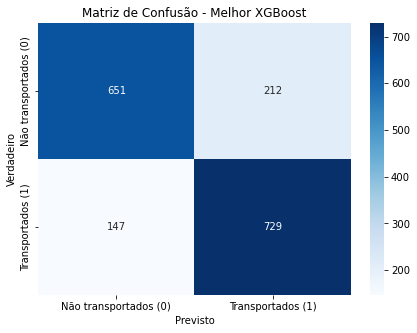

In [15]:
cm_xgb_best = confusion_matrix(Y_test_split, y_pred_xgb_best)

plt.figure(figsize=(7, 5))
sns.heatmap(cm_xgb_best, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Previsto')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão - Melhor XGBoost')
plt.show()

## Salvando os arquivos para submissão

Aqui vou salvar os 3 arquivos para submissão do Kaggle, onde os modelos foram usados para prever os resultados dos dados de teste.

In [22]:
proc_test2 = proc_test.copy()
predics = best_rf_model.predict(proc_test2.drop('PassengerId', axis=1))

predics_bool = predics.astype(bool)

submission_df = pd.DataFrame({
    'PassengerId': proc_test['PassengerId'],
    'Transported': predics_bool
})

submission_df.to_csv('submission_rf2025.csv', index=False)

In [ ]:
predics = best_lgbm_model.predict(proc_test2.drop('PassengerId', axis=1))

predics_bool = predics.astype(bool)

submission_df = pd.DataFrame({
    'PassengerId': proc_test['PassengerId'],
    'Transported': predics_bool
})

submission_df.to_csv('submission_lgbm2025.csv', index=False)

In [24]:
predics = best_xgb_model.predict(proc_test2.drop('PassengerId', axis=1))

predics_bool = predics.astype(bool)

submission_df = pd.DataFrame({
    'PassengerId': proc_test['PassengerId'],
    'Transported': predics_bool
})

submission_df.to_csv('submission_xgb2025.csv', index=False)